In [ ]:
#pip install yfinance --upgrade --no-cache-dir

In [ ]:
#pip install pybind11
#pip install path/cvxpy‑version.whl
#pip install riskfolio-lib

In [13]:
import riskfolio as rp
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

ModuleNotFoundError: No module named 'riskfolio'

In [ ]:
acoes = ['ITUB4.SA', 'BBDC4.SA', 'DIRR3.SA', 'JBSS3.SA','GUAR3.SA', 'PSSA3.SA']

ydata = yf.download(acoes, '2015-01-01', '2019-12-31', '1d');
dados = ydata["Adj Close"]

In [5]:
dados = dados *100 / dados.iloc[0]
#display(dados)

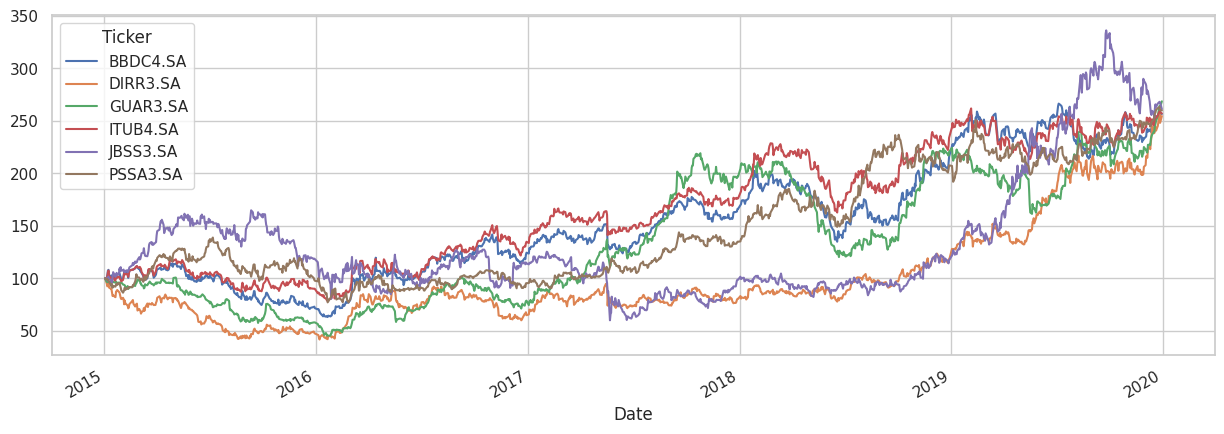

In [6]:
dados.plot(figsize = (15,5));

In [7]:
dados_chg = dados.pct_change()
dados_chg = dados_chg.fillna(0)

In [8]:
#Preparação dos dados e otimização do portfólio

port = rp.Portfolio(returns=dados_chg)

method_mu='hist' # Expectativa de retorno baseada no histórico das ações.
method_cov='hist' # Cálculo de covariância baseada no histórico das ações.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # MV: desvio padrão, MSV: Semi-Desvio Padrão, CVaR: Valor em Risco Condicional
obj = 'Sharpe' # Função objetivo. Pode ser: MinRisk, MaxRet, Utility or Sharpe
rf_anual = 0.12 # Taxa de retorno livre de risco (anual)

rf=((1+rf_anual)**(1/252))-1 #Ajuste da Taxa de retorno livre de risco
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf)

display(w.T)

,BBDC4.SA,DIRR3.SA,GUAR3.SA,ITUB4.SA,JBSS3.SA,PSSA3.SA
weights,0.000284,0.165352,0.25645,0.08965,0.210743,0.277521


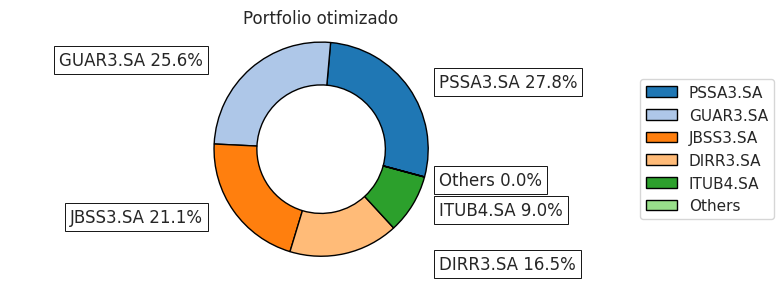

In [9]:
# Plot do portfólio

ax = rp.plot_pie(w=w, title='Portfolio otimizado', others=0.05, nrow=25, cmap = "tab20",
                 height=3, width=8, ax=None)

In [10]:
# Cálculo dos pontos que foram a fronteira eficiente

points = 50
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf)

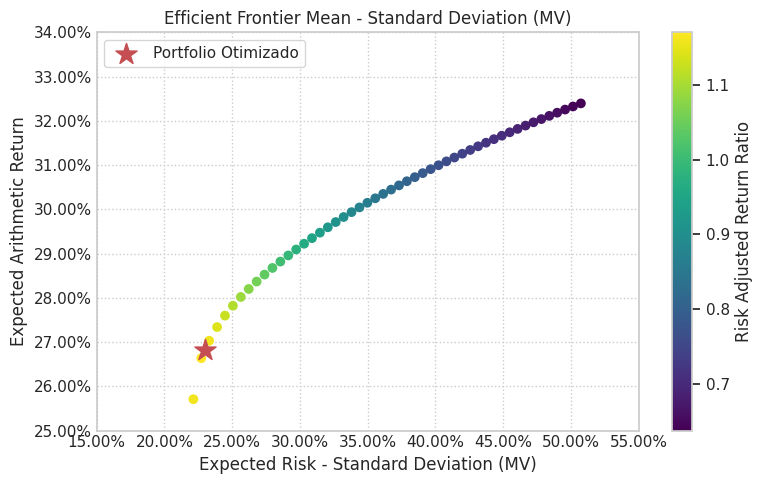

In [11]:
#Plot da fronteira eficiente

label = 'Portfolio Otimizado' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=5, width=8, ax=None)

In [12]:
#Report

#ax = rp.jupyter_report(returns, w, rm=rm)
rp.excel_report(returns, w)

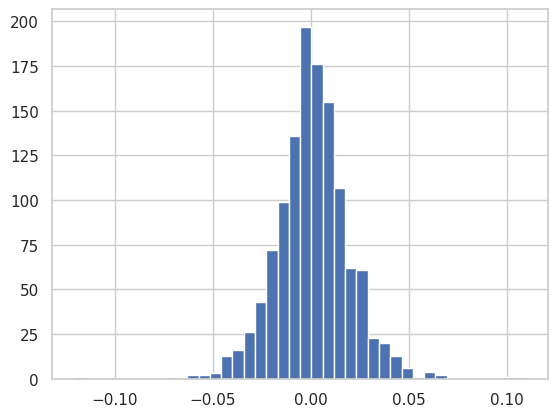

In [13]:
#Histograma dos retornos diários

plt.hist(dados_chg['ITUB4.SA'],bins=40);

In [14]:
# Cálculo do VaR não paramétrico (valor 100.000 )

q = dados_chg.quantile(q = 0.05, interpolation ='lower')
print('Quant:', q, q*100000)

Quant: Ticker
BBDC4.SA   -0.030751
DIRR3.SA   -0.037490
GUAR3.SA   -0.031496
ITUB4.SA   -0.028634
JBSS3.SA   -0.039152
PSSA3.SA   -0.031211
Name: 0.05, dtype: float64 Ticker
BBDC4.SA   -3075.074891
DIRR3.SA   -3749.041909
GUAR3.SA   -3149.610956
ITUB4.SA   -2863.412440
JBSS3.SA   -3915.170826
PSSA3.SA   -3121.132320
Name: 0.05, dtype: float64


In [16]:
#Limite de de alocação em um ativo

asset_classes = {'Assets': ['ITUB4.SA', 'BBDC4.SA', 'DIRR3.SA', 'JBSS3.SA','GUAR3.SA', 'PSSA3.SA'],
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False],
               'Type': ['All Assets'],
               'Set': [''],
               'Position': [''],
               'Sign': ['<='],
               'Weight': [0.25],
               'Type Relative': [''],
               'Relative Set': [''],
               'Relative': [''],
               'Factor': ['']}

constraints = pd.DataFrame(constraints)

display(constraints)
print(asset_classes)

A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'MinRisk'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf)

display(w.T)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,0.25,,,,


     Assets                Industry
1  BBDC4.SA  Consumer Discretionary
2  DIRR3.SA  Consumer Discretionary
4  GUAR3.SA        Consumer Staples
0  ITUB4.SA  Consumer Discretionary
3  JBSS3.SA        Consumer Staples
5  PSSA3.SA                  Energy


,BBDC4.SA,DIRR3.SA,GUAR3.SA,ITUB4.SA,JBSS3.SA,PSSA3.SA
weights,1.209178e-08,0.130281,0.25,0.25,0.119719,0.25
